# 𝔻𝕖𝕔𝕖𝕟𝕥ℕ𝕖𝕥: 𝕕𝕚𝕤-𝕖𝕟𝕥-𝕒𝕟𝕘𝕝𝕖𝕕 𝕟𝕖𝕥
Goal: create a neural network with disentangled early hidden layers. We want to analyse which textures contribute to the predictions.

In this notebook you can

1) train one or multiple DecentBlocks
  * we use a supervised contrastive loss function

2) train a DecentNet
  * we use the cross entropy loss
  * we freeze and use the DecentBlocks as part of the DecentNet
  * a fusion layer is the bridge between the DecentBlocks and the combined layers

3) Baseline

4) NOT HERE RIGHT NOW visualise the DecentBlocks and DecentNet (work in progress)
  * DeepDreams
  * Feature maps
  * Filters


8) BIMT with CONV
* use freeze, dropout and set channel to all zeros combination
* https://discuss.pytorch.org/t/freezing-part-of-the-layer-weights/9457/7

Todos:
* [ ] metrics / tensorboard


MIL: https://www.sciencedirect.com/science/article/pii/S0010482522004930

# Imports

In [1]:
# basics
import os
import sys
import time
import math
import random

# data
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch.utils.data.sampler import Sampler
from torchsummary import summary
from torchvision import transforms, datasets
from torchvision.models import shufflenet_v2_x1_0, resnet50


In [2]:
import sys
sys.path.insert(0, "helper")
from helper.dataset.transform.transform import ToTensor, ResizeCrop, RandomAugmentations, Normalise
from helper.dataset.transform.two_crop import *
from helper.compute.loss.supcon import SupConLoss
from helper.sampler.mixed_batch import MixedBatchSampler
from helper.dataset.concept import ClusterConceptDataset, PosNegConceptDataset
from helper.model.decentblock import *


# metrics
from sklearn.metrics import f1_score

try:
    from torchvision.models import ShuffleNet_V2_X1_0_Weights
except:
    pass

C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Experiment Configs

In [3]:
class Configs():

    def __init__(self):
        
        # general (half of these not in use)
        self.num_workers = 0
        self.epochs = 50
        self.n_samples_per_class_per_batch = 10

        # optimisation
        self.learning_rate = 0.01
        self.weight_decay = 1e-4
        self.momentum = 0.9

        # data - make sure it is the same size for quilted images
        self.image_size = 500

        self.prefix = "tmp"
        
        self.device = "cpu" # "cuda:0" if torch.cuda.is_available() else "cpu"
        
        # =============================================================================
        # Paths
        # =============================================================================
        
        # we read and write to an external directory!!
        self.base_path = r"C:/Users/Prinzessin/projects/decentnet"
        if not os.path.exists(self.base_path):
            os.makedirs(self.base_path)
        os.chdir(self.base_path) # this is now the main directory !!!!!!!!!!!!!!!!!!!!
        
        # input for decentblock
        self.csv_filenames =     [f"results/{self.prefix}/masks_info_label.csv"]
        self.concepts_path =     f"data/{self.prefix}/concepts"
        
        # input for decentnet
        self.train_path =        r"data/images/train"
        self.val_path =          r"data/images/val"
        self.test_path =         r"data/images/test"

        # output
        self.ckpt_net_path =     f"results/{self.prefix}/ckpts/decentnet"
        self.ckpt_blocks_path =  f"results/{self.prefix}/ckpts/decentblock"
        self.results_path =      f"results/{self.prefix}"
        
        if not os.path.exists(self.ckpt_net_path):
            os.makedirs(self.ckpt_net_path)
        if not os.path.exists(self.ckpt_blocks_path):
            os.makedirs(self.ckpt_blocks_path)
            
        # =============================================================================
        # activate function calls
        # =============================================================================    
            
        self.run_decentblocks = True
        self.run_decentnet = False
        self.run_baseline = False
        self.run_visualisation = False


# 𝔻𝕖𝕔𝕖𝕟𝕥𝕌𝕟𝕚𝕥

## DecentBlock Routine

In [ ]:
class DecentBlock_MLP_routine():
    
    def __init__(self, configs):
        
        self.configs = configs
        
    def set_loader(self, mode="train", ci_concept=0):
        # =============================================================================
        # construct data loader
        # =============================================================================
        
        p_aug = 0.5
            
        if mode == "train":
            dataset = PosNegConceptDataset(mode="train", channels=3, index_col=0, image_size=self.configs.image_size, csv_filenames=self.configs.csv_filenames, ci_concept=ci_concept, concepts_path=self.configs.concepts_path, p_aug=p_aug)
            # dataset = EyeDataset(mode="train", ci_concept=ci_concept, image_size=self.configs.image_size)
            mbs = MixedBatchSampler(dataset.get_class_labels(), n_samples_per_class_per_batch=self.configs.n_samples_per_class_per_batch)
            loader = torch.utils.data.DataLoader(
                dataset, 
                batch_sampler = mbs,
                num_workers=self.configs.num_workers)
        elif mode == "val":
            dataset = PosNegConceptDataset(mode="val", channels=3, index_col=0, image_size=self.configs.image_size, csv_filenames=self.configs.csv_filenames, ci_concept=ci_concept, concepts_path=self.configs.concepts_path, p_aug=p_aug)
            loader = torch.utils.data.DataLoader(
                dataset, 
                batch_size=1, # should be 1
                shuffle=False,
                num_workers=self.configs.num_workers)

        return loader

    def set_optimizer(self, model):
        # =============================================================================
        # =============================================================================

        optimizer = optim.SGD(model.parameters(),
                                lr=self.configs.learning_rate,
                                momentum=self.configs.momentum,
                                weight_decay=self.configs.weight_decay)
        
        return optimizer



    def save_model(self, model, optimizer, epoch, save_file):
        # =============================================================================
        # =============================================================================

        state = {
            'model': model.encoder.state_dict(),
            'epoch': epoch,
        }
        torch.save(state, save_file)
        del state

    def train(self, loader, model, criterion, optimizer, epoch):
        # =============================================================================
        # DecentBlock
        # one epoch training
        # trainings pair (2) - 2 augmented versions
        # batch size (8)
        # image size (256 x 256)
        # (8 x (2 x (256 x 256) ) )
        
        model.train()
        loss_epoch = []    
        for idx, batch in enumerate(loader):

            #print("train "*10)
            
            images, labels = batch["img"], batch["lbl"]
            
            images = torch.cat([images[0], images[1]], dim=0)

            batch_size = labels.shape[0]
            
            features = model(images.to(self.configs.device))
            f1, f2 = torch.split(features, [batch_size, batch_size], dim=0)
            features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)        
            loss = criterion(features, labels)

            # SGD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                    
            loss_epoch.append(loss.detach().cpu().numpy().item())

            #print("+"*50)
            
        return np.mean(loss_epoch)


    def val(self, loader, model, criterion, epoch):
        # =============================================================================
        # validation decentblock
        # trainings pair (2) - 2 augmented versions
        # batch size (8)
        # image size (256 x 256)
        # (8 x (2 x (256 x 256) ) )
        # =============================================================================
        
        model.eval()
        loss_epoch = []    
        with torch.no_grad():
            for idx, batch in enumerate(loader):
            
                images, labels = batch["image"], batch["label"]
                
                images = torch.cat([images[0], images[1]], dim=0)

                batch_size = labels.shape[0]

                features = model(images.to(self.configs.device))
                f1, f2 = torch.split(features, [batch_size, batch_size], dim=0)
                features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)        
                loss = criterion(features, labels)

                loss_epoch.append(loss.detach().cpu().numpy().item())

        return np.mean(loss_epoch)

def decentblock_routine(configs):
    
    
    temp = 0.07
    criterion = SupConLoss(temperature=temp)

    run = DecentBlock_MLP_routine(configs=configs)

    # todo
    concept_list = list(range(7))

    for ci_concept in concept_list:
        print(configs.concepts_path)
        # for ci_concept in concept_list:

        #print("concept", ci_concept)

        decent_block_mlp = DecentBlock(None, None, 128, device=configs.device, mode="train_mlp")
        decent_block_mlp = decent_block_mlp.to(configs.device)
        criterion = criterion.to(configs.device)

        # build data loader
        train_loader = run.set_loader(mode="train", ci_concept=ci_concept)
        # val_loader = run.set_loader(mode="val", batch_size=1, ci_concept=ci_concept)

        # print("train_loader:", train_loader.__len__())
        # print("val_loader:", val_loader.__len__())
        
        # build optimizer
        optimizer = run.set_optimizer(decent_block_mlp)

        best_loss = 0
        # training routine
        for epoch in range(1, configs.epochs + 1):

            # train for one epoch
            loss_train_epoch = run.train(train_loader, decent_block_mlp, criterion, optimizer, epoch)        
            #loss_val_epoch = run.val(val_loader, decent_block_mlp, criterion, iterations)

            #print("iter: ", iter)
            #print("loss_train_epoch", loss_train_epoch)
            #print("loss_val_epoch", loss_val_epoch)
            
            #if epoch < 5: # for the first 5 epochs
            #    best_loss = loss_val_epoch
            #elif best_loss > loss_val_epoch: # then if loss is lower than best loss (aka better)
            #    best_loss = loss_val_epoch

            best_loss = loss_train_epoch
            save_file = os.path.join(ckpt_blocks_path, f'{prefix}_mlp_{ci_concept}_ep{iter}_{round(best_loss, 4)}.ckpt')
            run.save_model(decent_block_mlp, optimizer, iter, save_file)

        # save the last model
        #save_file = os.path.join(ckpt_net_path, f'mlp_{ci_concept}_last_{round(loss_val_epoch, 4)}.ckpt')
        #run.save_model(decent_block_mlp, optimizer, iter, save_file)


# 𝔻𝕖𝕔𝕖𝕟𝕥ℕ𝕖𝕥

**How to freeze layers**

The layers of DecentBlocks need to be frozen while training the DecentNet

* Just adding this here for completeness. You can also freeze parameters in place without iterating over them with requires_grad_ (API).

* For example say you have a RetinaNet and want to just fine-tune on the heads

```
class RetinaNet(torch.nn.Module):
    def __init__(self, ...):
        self.backbone = ResNet(...)
        self.fpn = FPN(...)
        self.box_head = torch.nn.Sequential(...)
        self.cls_head = torch.nn.Sequential(...)
```

Then you could freeze the backbone and FPN like this:

* Getting the model
```
retinanet = RetinaNet(...)
```

* Freezing backbone and FPN
```
retinanet.backbone.requires_grad_(False)
retinanet.fpn.requires_grad_(False)
```



**Fusing** 

Fusing methods: mostly element-wise sum or maximum operations have been studied for fusing CNN feature maps from multiple views for the purpose of classification. Correspondence between multiple views is thereby lost, while fusion by concatenation or convolution were found to efficiently model correspondences between different views for other learning tasks. Comparative evaluations of different strategies for image classification are either missing or yield contradicting results.

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0245230

In early fusion, convolutional feature maps from the different CNN branches are stacked and subsequently processed together. 


We consider two different approaches for depth reduction: 
* (1) early fusion (max): max-pooling of the stacked feature map across the nV views
* (2) early fusion (conv): 1 × 1 convolution across the depth of the stacked feature maps.

stacking, 1x1 conv || max



* In order to further achieve effective fusion of local and global features of images, this paper uses gated fusion sub-networks to adaptively fuse multiple feature maps obtained based on branch networks



https://github.com/sheryl-ai/MVGCN/blob/master/models.py
```
    def _view_pool(self, view_features, name, method='max'):
        """Max pooling of size p. Should be a power of 2."""

        vp = tf.expand_dims(view_features[0], 0) # eg. [100] -> [1, 100]
        for v in view_features[1:]:
            v = tf.expand_dims(v, 0)
            vp = tf.concat([vp, v], axis=0)
        print ('vp before reducing:', vp.get_shape().as_list())
        if method == 'max':
            vp = tf.reduce_max(vp, [0], name=name)
        elif method == 'mean':
            vp = tf.reduce_mean(vp, [0], name=name)
        return vp
```    
    
    
https://github.com/VChristlein/dgmp/blob/master/clamm/pooling.py


Fusion of features after layer three of a CNN. The features from two streams are passed through max pooling, convolution, batch normalization and ReLU layers. The two outputs are then concatenated and form the input for the fourth layer.


## Model

In [ ]:
from torch.autograd import Variable
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.models import resnet50, shufflenet_v2_x1_0
import os

class DecentNet_v1(nn.Module):
    
    # for freezing in train code: retinanet.backbone.requires_grad_(False)
        
    def __init__(self, num_classes=3, plot=False):
        super(DecentNet_v1, self).__init__()
        
        print("init decentnet start")

        self.num_classes = num_classes
        
        # get ckpt files
        block_ckpts = os.listdir(ckpt_blocks_path)

        # loads blocks
        self.decent_blocks = nn.ModuleList([])

        decent_block_116 = ""
        
        amount_of_blocks = 0
        for block_ckpt in block_ckpts:
            
            # we use a shufflenet pretrained on data from a previous step
            # these layer should be frozen during training of this model
            decent_block = shufflenet_v2_x1_0()
            decent_block.fc = nn.Identity()

            # load shuffle net weights here
            checkpoint = torch.load(os.path.join(ckpt_blocks_path, block_ckpt))
            decent_block.load_state_dict(checkpoint['model'])

            if True:
              # remove layers - this line might be wrong too
              decent_block_116 = nn.Sequential(*(list(decent_block.children())[:-4]), 
                                              nn.Conv2d(116, 5, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1)),
                                              nn.BatchNorm2d(5),
                                              nn.ReLU()
                                              ).to(device)
            else:
              # not working for some reason ... needs to be in nn.Seq
              decent_block_116 = nn.Sequential(*(list(decent_block.children())[:-4])).to(device)
              self.decent_block_reduction = nn.Conv2d(116, 5, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1))
            
            self.decent_blocks.append(decent_block_116) # 116 output filters
            amount_of_blocks += 1


        if plot:
            print("original")
            print("*"*50)
            print(decent_block)
            print("116")
            print("*"*50)
            print(decent_block_116)
                
        # layer between decent blocks and combined layers
        if False:
          # single conv 1x1 ??
          self.fusion_layer = nn.Conv2d(5*amount_of_blocks, 512, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1))
        else:
          # conv, batchnorm and relu
          self.fusion_layer = nn.Sequential(
                nn.Conv2d(5*amount_of_blocks, 512, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1)),
                nn.BatchNorm2d(512),
                nn.ReLU()
          )
        
        # combined layers
        r50 = resnet50(pretrained=True)
        
        # remove early layers
        r50.conv1 = nn.Identity()
        r50.bn1 = nn.Identity()
        r50.relu = nn.Identity()
        r50.maxpool = nn.Identity()
        r50.layer1 = nn.Identity()
        r50.layer2 = nn.Identity()  
                
        # change classification head
        in_features = r50.fc.in_features
        r50.fc = nn.Linear(in_features, self.num_classes)

        self.combined_layers = r50 
        
        print("init decentnet done")
        
        
    def forward(self, image):
        
        
        # idea: use combined very early layers (pretrained on any dataset): edges
        # (maybe for later, needs to be taken into account for the decent block training)
        
        
        # get output for each decent block
        block_outputs = []
        for i, block in enumerate(self.decent_blocks):
            block_output = block(image)
            # block_output = self.decent_block_reduction(block_output)
            block_outputs.append(block_output)
            
            # print("block output shape:", block_output.shape)
            
        # concat features
        concat = torch.cat(block_outputs, dim=1)
        # print("concat shape:", concat.shape)

        # fusion layer
        fusion = self.fusion_layer(concat)

        # print("fusion output:", fusion.shape)
        
        # combined layers
        feature_vector = self.combined_layers(fusion)
            
        # print("combined layers output shape", feature_vector.shape) 
        # print(feature_vector.shape) 
                        
        return feature_vector
    

class DecentNet_v2(nn.Module):
    
    # for freezing in train code: retinanet.backbone.requires_grad_(False)
        
    def __init__(self, num_classes=3, plot=False):
        super(DecentNet_v2, self).__init__()
        
        print("init decentnet start")

        self.num_classes = num_classes
        
        # get ckpt files
        block_ckpts = os.listdir(ckpt_blocks_path)

        # loads blocks
        self.decent_blocks = nn.ModuleList([])

        decent_block_116 = ""
        
        amount_of_blocks = 0
        for block_ckpt in block_ckpts:
            
            # we use a shufflenet pretrained on data from a previous step
            # these layer should be frozen during training of this model
            decent_block = shufflenet_v2_x1_0()
            decent_block.fc = nn.Identity()

            # load shuffle net weights here
            checkpoint = torch.load(os.path.join(ckpt_blocks_path, block_ckpt))
            decent_block.load_state_dict(checkpoint['model'])

            # remove layers - this line might be wrong too
            decent_block_116 = nn.Sequential(*(list(decent_block.children())[:-4])).to(device)

            
            
            self.decent_blocks.append(decent_block_116) # 116 output filters
            amount_of_blocks += 1

        if plot:
            print("original")
            print("*"*50)
            print(decent_block)
            print("116")
            print("*"*50)
            print(decent_block_116)
                
        # layer between decent blocks and combined layers
        # todo, figure out how to get the 116 automatically - 58 * 2
        # fusion_conv
        if True:
            self.fusion_layer = nn.Conv2d(116*amount_of_blocks, 512, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1))
        else:
            self.fusion_layer = nn.Sequential(
                nn.Conv2d(116*amount_of_blocks, 512, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1)),
                nn.BatchNorm2d(512),
                nn.ReLU()
            )
        
        # combined layers
        r50 = resnet50(pretrained=True)
        
        # remove early layers
        r50.conv1 = nn.Identity()
        r50.bn1 = nn.Identity()
        r50.relu = nn.Identity()
        r50.maxpool = nn.Identity()
        r50.layer1 = nn.Identity()
        r50.layer2 = nn.Identity()  
        
        # torch.nn.Sequential(*list(r50.children())[3:]) - this is not working
        
        # change classification head
        in_features = r50.fc.in_features
        r50.fc = nn.Linear(in_features, self.num_classes)
      
        self.combined_layers = r50 
        
        print("init decentnet done")
        
        
    def forward(self, image):
        
        
        # idea: use combined very early layers (pretrained on any dataset): edges
        # (maybe for later, needs to be taken into account for the decent block training)
        
        
        # get output for each decent block
        block_outputs = []
        for i, block in enumerate(self.decent_blocks):
            block_output = block(image)
            block_outputs.append(block_output)
            # print("block output shape:", block_output.shape)
            
        # concat features
        concat = torch.cat(block_outputs, dim=1)
        # print("concat shape:", concat.shape)

        # fusion layer
        fusion = self.fusion_layer(concat)
        
        # combined layers
        feature_vector = self.combined_layers(fusion)
            
        # print("combined layers output shape", feature_vector.shape) 
        # print(feature_vector.shape) 
                        
        return feature_vector
    
    

class DecentNet_v3(nn.Module):
    
    # for freezing in train code: retinanet.backbone.requires_grad_(False)
        
    def __init__(self, num_classes=3):
        super(DecentNet_v1, self).__init__()
        
        print("init decentnet start")

        self.num_classes = num_classes
        
        # prepare early blocks list
        ckpt_early_blocks = os.listdir(ckpt_early_blocks_path)
        self.early_blocks = nn.ModuleList([])
        early_block_116 = None
        for i, early_block in enumerate(ckpt_early_blocks):            
            early_block_116 = DecentBlock_Shuffle_EarlyBlock(ckpt_early_blocks_path, early_block, out_channels=5)
            self.early_blocks.append(early_block_116) # 116 output filters
                
        # prepare early fusion (optional)
        self.early_fusion_module = None
        
        # prepare late blocks list (optional)
        self.late_blocks = nn.ModuleList([])
        self.late_blocks.append(DecentBlock_ResNet_LateBlock())
        
        # prepare late fusion (optional)
        self.late_fusion_module = None
        
        # prepare head blocks list
        self.head_blocks = nn.ModuleList([])
        self.late_blocks.append(DecentBlock_ResNet_LateBlock())

        print("init decentnet done")
        
        
    def forward(self, x):
        
        # early block(s)
        block_outputs = []
        for i, block in enumerate(self.early_blocks):
            block_output = block(x)
            block_outputs.append(block_output)
            
        # concat + fusion
        if block_outputs:
            x = torch.cat(block_outputs, dim=1)
            x = self.early_fusion_module(x)
        
        # late block(s)
        block_outputs = []
        for i, block in enumerate(self.late_blocks):
            block_output = block(x)
            block_outputs.append(block_output)
            
        # concat + fusion
        if block_outputs:
            x = torch.cat(block_outputs, dim=1)
            x = self.late_fusion_module(x)
        
        # head block(s) (multi-task)            
        model_outputs = {}
        for i, block in enumerate(self.head_blocks):
            # model output of head = pass feature vector through head
            model_outputs[type(head).__name__] = fc_layer(x)
        
        return model_outputs
        

## DecentNet Routine

In [ ]:
class DecentNet_routine():

    def set_loader(self, mode="train", batch_size=2, num_workers=0, image_size=500):
        # construct data loader
                    
        if mode == "train":
                train_transform = transforms.Compose([
                    ResizeCrop(image_size=image_size),
                    RandomAugmentations(),
                    ToTensor(),
                    Normalise()
                ])

                train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)

                print(set(train_dataset.targets))

                loader = torch.utils.data.DataLoader(
                    train_dataset, 
                    batch_size=batch_size, 
                    shuffle=True,
                    num_workers=num_workers)
            
        elif mode == "val":

            val_transform = transforms.Compose([
                    ResizeCrop(image_size=image_size),
                    ToTensor(),
                    Normalise()
            ])

            val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)
            loader = torch.utils.data.DataLoader(
                    val_dataset, 
                    batch_size=batch_size, # should be 1
                    shuffle=False,
                    num_workers=num_workers)

        elif mode == "test":

            test_transforms = transforms.Compose([
                    ResizeCrop(image_size=image_size),
                    ToTensor(),
                    Normalise()
            ])

            test_dataset = datasets.ImageFolder(root=test_path, transform=test_transforms)
            loader = torch.utils.data.DataLoader(
                    test_dataset, 
                    batch_size=batch_size, # should be 1 
                    shuffle=False,
                    num_workers=num_workers)
            

        return loader

    def set_optimizer(self, model):
        optimizer = optim.SGD(model.parameters(),
                                lr=learning_rate,
                                momentum=momentum,
                                weight_decay=weight_decay)
        
        return optimizer

    def save_model(self, model, optimizer, epoch, save_file):
        state = {
            'model': model.state_dict(),
            'epoch': epoch,
        }
        torch.save(state, save_file)
        del state

    def train(self, loader, model, criterion, optimizer, epoch):
        """one epoch training"""
        
        model.train()
        loss_epoch = []
        ground_truth_all = []
        model_output_all = []  
        for idx, (images, labels) in enumerate(loader):
            

            # images, labels = batch["image"], batch["label"]
                        
            model_output = model(images.to(device))
            loss = criterion(model_output, labels.to(device))

            # SGD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                    
            loss_epoch.append(loss.detach().cpu().numpy().item())

            _, highest_class = torch.max(model_output, 1)    
            highest_class = highest_class.detach().cpu().numpy()    

            ground_truth_all.extend(labels.detach().cpu().numpy())
            model_output_all.extend(highest_class)

        print(ground_truth_all)
        print(model_output_all)
            
        f_score_epoch = f1_score(y_true = ground_truth_all, y_pred = model_output_all, average="weighted", labels=[0,1,2])

        return np.mean(loss_epoch), f_score_epoch


    def val(self, loader, model, criterion, epoch):
        # decentnet
        # with labels
        """validation"""
        
        model.eval()
        loss_epoch = []   
        ground_truth_all = []
        model_output_all = [] 

        with torch.no_grad():
            for idx, (images, labels) in enumerate(loader):
            
                # images, labels = batch["image"], batch["label"]
                        
                model_output = model(images.to(device))
                loss = criterion(model_output, labels.to(device))
                        
                loss_epoch.append(loss.detach().cpu().numpy().item())

                _, highest_class = torch.max(model_output, 1)    
                highest_class = highest_class.detach().cpu().numpy()    

                ground_truth_all.extend(labels.detach().cpu().numpy())
                model_output_all.extend(highest_class)

        print(ground_truth_all)
        print(model_output_all)

        f_score_epoch = f1_score(y_true = ground_truth_all, y_pred = model_output_all, average="weighted", labels=[0,1,2])

        return np.mean(loss_epoch), f_score_epoch


    def test(self, loader, model):
        # decentnet - results for non existant labels
        # without labels
        
        model.eval()
        highest_classes = [] 

        with torch.no_grad():
            for idx, (images, labels) in enumerate(loader):
            
                # images, labels = batch["image"], batch["label"]
                        
                model_output = model(images.to(device))
                _, highest_class = torch.max(model_output, 1)    
                highest_class = highest_class.detach().cpu().numpy()

                highest_classes.extend(highest_class)    


        print(highest_classes)

        df = pd.DataFrame({'Prediction': highest_classes})
        df.to_csv("test_decentnet.csv")


    def visualise_with_labels(self, loader, model):
        pass


def decentnet_routine():
    criterion = nn.CrossEntropyLoss()
    run = DecentNet_routine()

    decentnet = DecentNet_v2(num_classes=3).to(device)

    # freeze decent blocks
    if True:
        for i, child in enumerate(decentnet.decent_blocks.children()):
            # exclude the conv layer (or sequential???) - needs to be trainable
            for param in child[:-1].parameters():
                param.requires_grad = False
    else:
        # v1, without conv layer (that is trainable)
        decentnet.decent_blocks.requires_grad_(False)

    
    decentnet = decentnet.to(device)
    criterion = criterion.to(device)

    # set data loader
    train_loader = run.set_loader(mode="train", batch_size=8, num_workers=num_workers, image_size=image_size)
    val_loader = run.set_loader(mode="val", batch_size=1, num_workers=num_workers, image_size=image_size)

    # set optimizer
    optimizer = run.set_optimizer(decentnet)

    best_loss = 0
    iter = 0
    # training routine
    for iter in range(1, iterations + 1):

            # train for one epoch
            loss_train_epoch, fscore_train_epoch = run.train(loader=train_loader, model=decentnet, criterion=criterion, optimizer=optimizer, epoch=epoch)        
            loss_val_epoch, fscore_val_epoch = run.val(loader=val_loader, model=decentnet, criterion=criterion, epoch=epoch)

            print("iter: ", iter)
            print(loss_train_epoch)
            print(fscore_train_epoch)
            print(loss_val_epoch)
            print(fscore_val_epoch)
            
            if iter < 3: # for the first 3 epochs
                best_loss = loss_val_epoch
            elif best_loss > loss_val_epoch: # then if loss is lower than best loss (aka better)
                best_loss = loss_val_epoch
                save_file = os.path.join(ckpt_net_path, f'decentnet_epoch_{iter}_{round(best_loss, 4)}.ckpt')
                run.save_model(decentnet, optimizer, iter, save_file)

    # save the last model
    save_file = os.path.join(ckpt_net_path, f'decentnet_last_{round(loss_val_epoch, 4)}.ckpt')
    run.save_model(decentnet, optimizer, iter, save_file)





# 𝔹𝕒𝕤𝕖𝕝𝕚𝕟𝕖 ℝ𝕖𝕤ℕ𝕖𝕥

## Model

* early stopping: https://pythonguides.com/pytorch-early-stopping/

In [ ]:
class DecentBaseline(nn.Module):
    
    def __init__(self, num_classes=3):
        super(DecentBaseline, self).__init__()
        
        print("init baseline start")

        self.num_classes = num_classes
        
        # resnet 50
        r50 = resnet50(pretrained=True)

        # change classification head
        in_features = r50.fc.in_features
        r50.fc = nn.Linear(in_features, self.num_classes)
        
        self.r50 = r50 
        
        print("init baseline done")
        
        
    def forward(self, image):
        
        # resnet 50
        feature_vector = self.r50(image)
                        
        return feature_vector
    
    

    

## Baseline Routine

In [ ]:
def baseline_routine():

    criterion = nn.CrossEntropyLoss()
    run = DecentNet_routine()

    ########## 
    # TRAIN and VAL Decent Baseline
    ##########

    baseline = DecentBaseline(num_classes=3).to(device)


    baseline = baseline.to(device)
    criterion = criterion.to(device)

    # build data loader
    train_loader = run.set_loader(mode="train", batch_size=8, num_workers=num_workers, image_size=image_size)
    val_loader = run.set_loader(mode="val", batch_size=1, num_workers=num_workers, image_size=image_size)

    # build optimizer
    optimizer = run.set_optimizer(baseline)

    best_loss = 0
    iter = 0
    # training routine
    for iter in range(1, iterations + 1):

        # train for one epoch
        loss_train_epoch, fscore_train_epoch = run.train(loader=train_loader, model=baseline, criterion=criterion, optimizer=optimizer, epoch=iter)        
        loss_val_epoch, fscore_val_epoch = run.val(loader=val_loader, model=baseline, criterion=criterion, epoch=epoch)

        print("iter: ", iter)
        print(loss_train_epoch)
        print(fscore_train_epoch)
        print(loss_val_epoch)
        print(fscore_val_epoch)
        
        if iter < 3: # for the first 3 epochs
            best_loss = loss_val_epoch
        elif best_loss > loss_val_epoch: # then if loss is lower than best loss (aka better)
            best_loss = loss_val_epoch
            save_file = os.path.join(ckpt_net_path, f'baseline_epoch_{iter}_{round(best_loss, 4)}.ckpt')
            run.save_model(baseline, optimizer, iter, save_file)

    # save the last model
    save_file = os.path.join(ckpt_net_path, f'baseline_last_{round(loss_val_epoch, 4)}.ckpt')
    run.save_model(baseline, optimizer, iter, save_file)


# 𝔹𝕣𝕒𝕚𝕟-𝕀𝕟𝕤𝕡𝕚𝕣𝕖𝕕 𝕄𝕠𝕕𝕦𝕝𝕒𝕣 𝕋𝕣𝕒𝕚𝕟𝕚𝕟𝕘 (𝔹𝕀𝕄𝕋)
* https://github.com/KindXiaoming/BIMT/blob/main/mnist_3.5.ipynb

## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Ellipse, Circle

from itertools import islice
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torchvision
from mpl_toolkits.mplot3d import Axes3D

## settings

In [2]:
seed = 19
np.random.seed(seed)
torch.manual_seed(seed)

# i think steps need to be smaller than data size
batch_size = 30

log = 1000
lamb = 0.01
swap_log = 1000
plot_log = 1000

device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Datasest

In [3]:
# todo change here
if False:
    from medmnist import OCTMNIST
    train = OCTMNIST(split="train", transform=torchvision.transforms.ToTensor(), download=True)
    test = OCTMNIST(split="test", transform=torchvision.transforms.ToTensor(), download=True) 
    class_amount = 4
    steps = 2000
    data_size = 80000
    mode = "octmnist"
elif True:
    from medmnist import RetinaMNIST
    t = torchvision.transforms.Compose([
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor()
         ])
    # torchvision.transforms.Grayscale(num_output_channels=1)
    train = RetinaMNIST(split="train", transform=t, download=True)
    test = RetinaMNIST(split="test", transform=t, download=True) 
    mode = "retinamnist"
    class_amount = 5
    steps = 500
    data_size = 1000
else:
    train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
    test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)
    class_amount = 10

    
train = torch.utils.data.Subset(train, range(data_size))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)



"""
if True:
    import medmnist
    #from medmnist import INFO
    #info = INFO['retinamnist']
    #DataClass = getattr(medmnist, info['python_class'])
    #train = DataClass(split='train', download=True)    
    #test = DataClass(split='test', download=True)    
    from medmnist import RetinaMNIST
    train = RetinaMNIST(split="train", transform=torchvision.transforms.ToTensor(), download=True)
    test = RetinaMNIST(split="test", transform=torchvision.transforms.ToTensor(), download=True)
else:
    #train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
    #test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)
    train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
    test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)

train = torch.utils.data.Subset(train, range(data_size))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

"""





C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using downloaded and verified file: C:\Users\Prinzessin\.medmnist\retinamnist.npz
Using downloaded and verified file: C:\Users\Prinzessin\.medmnist\retinamnist.npz


'\nif True:\n    import medmnist\n    #from medmnist import INFO\n    #info = INFO[\'retinamnist\']\n    #DataClass = getattr(medmnist, info[\'python_class\'])\n    #train = DataClass(split=\'train\', download=True)    \n    #test = DataClass(split=\'test\', download=True)    \n    from medmnist import RetinaMNIST\n    train = RetinaMNIST(split="train", transform=torchvision.transforms.ToTensor(), download=True)\n    test = RetinaMNIST(split="test", transform=torchvision.transforms.ToTensor(), download=True)\nelse:\n    #train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)\n    #test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)\n    train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)\n    test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTe

## biolinear 2D

In [4]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

#torch.set_default_tensor_type(torch.DoubleTensor)


class BioLinear2D(nn.Module):

    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1, out_ring=False):
        super(BioLinear2D, self).__init__()
        
        # dimensions
        self.in_dim = in_dim
        self.out_dim = out_dim
        # linear layer
        self.linear = nn.Linear(in_dim, out_dim)
        # fold ??
        self.in_fold = in_fold
        self.out_fold = out_fold
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0
        
        #compute input coordinates, shape: (in_dim_sqrt, in_dim_sqrt)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        in_dim_sqrt = int(np.sqrt(in_dim_fold))
        out_dim_sqrt = int(np.sqrt(out_dim_fold))
        x = np.linspace(1/(2*in_dim_sqrt), 1-1/(2*in_dim_sqrt), num=in_dim_sqrt)
        X, Y = np.meshgrid(x, x)
        self.in_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)
        
        # compute output coordinates, shape: (out_dim_sqrt, out_dim_sqrt)
        if out_ring:
            thetas = np.linspace(1/(2*out_dim_fold)*2*np.pi, (1-1/(2*out_dim_fold))*2*np.pi, num=out_dim_fold)
            self.out_coordinates = 0.5+torch.tensor(np.transpose(np.array([np.cos(thetas), np.sin(thetas)]))/4, dtype=torch.float)
        else:
            x = np.linspace(1/(2*out_dim_sqrt), 1-1/(2*out_dim_sqrt), num=out_dim_sqrt)
            X, Y = np.meshgrid(x, x)
            self.out_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)

        
    def forward(self, x):
        # forward of single linear layer
        return self.linear(x)

## bio MLP 2D

In [5]:
class BioMLP2D(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP2D, self).__init__()
        
        # example shp for 28x28 = (1st layer, 2nd layer, 3rd layer, number of classes) = (784, 100, 100, 4)
        
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth      
        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1
            
        linear_list = []
        for i in range(self.depth):
            out_shape = 0
            if i == 0:
                # for modular addition
                #linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=2))
                # for regression
                # first layer
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1))
            elif i == self.depth - 1:
                # last layer
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1, out_ring=True))
            else:
                # hidden layers
                linear_list.append(BioLinear2D(shp[i], shp[i+1]))
                
            print("i", i)
            print("bio linear shape", shp[i])
                
        # save all layers
        self.linears = nn.ModuleList(linear_list)
        
        print("shape", shp)
        print("in", shp[-2])
        print("out", shp[-1])        
        
        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size))
        
        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.5 # distance between two nearby layers
        self.in_perm = nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 30
        self.token_embedding = token_embedding
        
        print("done init")

    def forward(self, x):
        
        print("*"*50)
        print("next input")
        
        print("input size", x.shape)
        
        shp = x.shape
        x = x.reshape(shp[0],-1)
        print("reshape size 1", x.shape)
        
        shp = x.shape
        in_fold = self.linears[0].in_fold
        x = x.reshape(shp[0], in_fold, int(shp[1]/in_fold))
        print("reshape size 2", x.shape)
        
        x = x[:,:,self.in_perm.long()]
        print("reshape size 3", x.shape)
        
        x = x.reshape(shp[0], shp[1])
        print("more reshape size", x.shape)
        
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            
            print("linear itself shape", self.linears[i](x).shape)
            
            x = f(self.linears[i](x))
            print("i", i)
            print("linear output size", x.shape)
            
        print("this shp", x.shape)
        # 30 x 10 x 10 
        tmp_shape = x.shape       
        
        # final linear layer
        x = self.linears[-1](x)
        print("final linear output size", x.shape)
        
        out_perm_inv = torch.zeros(self.out_dim, dtype=torch.long)
        out_perm_inv[self.out_perm.long()] = torch.arange(self.out_dim)
        x = x[:,out_perm_inv]
        
        print("result", x.shape)
        
        #x = x[:,self.out_perm]
        
        return x
    
    def get_linear_layers(self):
        return self.linears
    
    def get_cc(self, weight_factor=2.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i]
            dist = torch.sum(torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0)),dim=2)
            
            #print("biolinear.linear.weight", biolinear.linear.weight)
            #print("weight_factor", weight_factor)
            #print("dist", dist)
            #print("self.l0", self.l0)
            
            cc += torch.mean(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0).to("cuda:0"))
            if bias_penalize == True:
                cc += torch.mean(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.mean(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc
    
    def swap_weight(self, weights, j, k, swap_type="out"):
        with torch.no_grad():  
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))
            
    def swap_bias(self, biases, j, k):
        with torch.no_grad():  
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp
    
    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron. 
        # Note: n layers of weights means n+1 layers of neurons.
        # (incoming, outgoing) * weights + biases are swapped. 
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            return
            # for images, do not allow input_perm
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm. do not allow input_perm for images
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : (incoming, outgoing) * weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index, score
    
    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)
            
    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id[0]:
            self.relocate_ij(i,j)
            
    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)


    

## Metrics

In [6]:
def accuracy(network, dataset, device, N=2000, batch_size=5):
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    correct = 0
    total = 0
    for x, labels in islice(dataset_loader, N // batch_size):
                
        #print(x.shape)
        logits = network(x.to(device))
        predicted_labels = torch.argmax(logits, dim=1)
        correct += torch.sum(predicted_labels == labels.to(device))
        total += x.size(0)
    return correct / total

def loss_f(network, dataset, device, N=2000, batch_size=5):
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss = 0
    total = 0
    for x, labels in islice(dataset_loader, N // batch_size):
        labels = labels.squeeze().long()
        logits = network(x.to(device))
        #print("logits", logits)
        #print("torch eye", torch.eye(10,)[labels]) 
        loss += torch.sum(( logits-torch.eye(class_amount,)[labels].to(device) )**2)
        total += x.size(0)
    return loss / total

def L2(model):
    L2_ = 0.
    for p in mlp.parameters():
        L2_ += torch.sum(p**2)
    return L2_

def rescale(model, alpha):
    for p in mlp.parameters():
        p.data = alpha * p.data
    

## sanity check

i 0
bio linear shape 784
i 1
bio linear shape 100
i 2
bio linear shape 100
shape (784, 100, 100, 5)
in 100
out 5
done init
**************************************************
BioMLP2D(
  (linears): ModuleList(
    (0): BioLinear2D(
      (linear): Linear(in_features=784, out_features=100, bias=True)
    )
    (1): BioLinear2D(
      (linear): Linear(in_features=100, out_features=100, bias=True)
    )
    (2): BioLinear2D(
      (linear): Linear(in_features=100, out_features=5, bias=True)
    )
  )
)
**************************************************
item torch.Size([30, 1, 28, 28])


  0%|          | 0/500 [00:00<?, ?it/s]

**************************************************
next input
input size torch.Size([30, 1, 28, 28])
reshape size 1 torch.Size([30, 784])
reshape size 2 torch.Size([30, 1, 784])
reshape size 3 torch.Size([30, 1, 784])
more reshape size torch.Size([30, 784])
linear itself shape torch.Size([30, 100])
i 0
linear output size torch.Size([30, 100])
linear itself shape torch.Size([30, 100])
i 1
linear output size torch.Size([30, 100])
this shp torch.Size([30, 100])
final linear output size torch.Size([30, 5])
result torch.Size([30, 5])


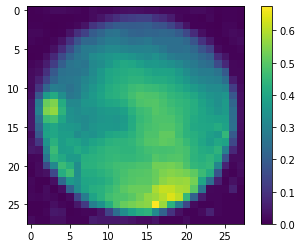

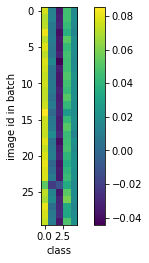

In [7]:
# width = 200
shape = (784, 100, 100, class_amount)
mlp = BioMLP2D(shp=shape)
mlp.to(device)

print("*"*50)
print(mlp)
print("*"*50)

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=0.0)

one_hots = torch.eye(class_amount, class_amount).to(device)

print("item", next(iter(train_loader))[0].shape)


def cycle(iterable):
    while True:
        for x in iterable:
            yield x
            
pbar = tqdm(islice(cycle(train_loader), steps), total=steps)

best_train_loss = 1e4
best_test_loss = 1e4
best_train_acc = 0.
best_test_acc = 0.


for x, label in pbar:

    mlp.train()
    plt.figure()
    plt.imshow(x[0].detach().cpu().numpy().transpose(1,2,0))
    plt.colorbar()
    a = mlp(x.to(device))
    plt.figure()
    plt.imshow(a.detach().cpu().numpy())
    plt.ylabel("image id in batch")
    plt.xlabel("class")
    plt.colorbar()
    break

if False:
    mlp.eval()
    print("Initial accuracy: {0:.4f}".format(accuracy(mlp, test, device, batch_size=batch_size)))


    # todo create this directory
    # or change in all following
    torch.save(mlp.state_dict(), "../results/retina_mnist/init.cptk")

## Training

In [8]:
test_accuracies = []
train_accuracies = []

step = 0
mlp.train()
pbar = tqdm(islice(cycle(train_loader), steps), total=steps)

best_train_loss = 1e4
best_test_loss = 1e4
best_train_acc = 0.
best_test_acc = 0.

if True:
#for i_batch, (x, label) enumerate(train_loader):

    for x, label in pbar:

        if step == int(steps/4):
            lamb *= class_amount
        elif step == int(steps/2):
            lamb *= class_amount

        label = label.squeeze().long()

        #print("image", x.type)
        #print(label)
        #print("label", label.shape)
        #print("one_hots[label]", one_hots[label])
        #print("one_hots[label]", one_hots[label].shape)

        mlp.train()
        optimizer.zero_grad()

        #print(label)
        loss_train = loss_fn(mlp(x.to(device)), one_hots[label]) # .long()
        cc = mlp.get_cc(weight_factor=2.0, no_penalize_last=True)
        total_loss = loss_train + lamb*cc
        total_loss.backward()
        optimizer.step()

        if step % log == 0:
            with torch.no_grad():
                mlp.eval()
                train_acc = accuracy(mlp, train, device).item()
                test_acc = accuracy(mlp, test, device).item()
                train_loss = loss_f(mlp, train, device).item()
                test_loss = loss_f(mlp, test, device).item()

                if train_acc > best_train_acc:
                    best_train_acc = train_acc
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                if train_loss < best_train_loss:
                    best_train_loss = train_loss
                if test_loss < best_test_loss:
                    best_test_loss = test_loss
                mlp.train()
                pbar.set_description("{:3.3f} | {:3.3f} | {:3.3f} | {:3.3f} | {:3.3f} ".format(train_acc, test_acc, train_loss, test_loss, cc))
        step += 1

        if step % swap_log == 0:
            mlp.relocate()

        if (step-1) % plot_log == 0:

            fig=plt.figure() # figsize=(30,15))
            ax=fig.add_subplot(projection='3d')

            ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
            ax.scatter(mlp.linears[0].in_coordinates[:,0].detach().cpu().numpy(), mlp.linears[0].in_coordinates[:,1].detach().cpu().numpy(),[0]*shape[0], s=5, alpha=0.5, c=train[46][0][0].detach().cpu().numpy()[:,::-1].reshape(-1,))
            ax.scatter(mlp.linears[1].in_coordinates[:,0].detach().cpu().numpy(), mlp.linears[1].in_coordinates[:,1].detach().cpu().numpy(),[1]*shape[1], s=5, alpha=0.5, color="black")
            ax.scatter(mlp.linears[2].in_coordinates[:,0].detach().cpu().numpy(), mlp.linears[2].in_coordinates[:,1].detach().cpu().numpy(),[2]*shape[2], s=5, alpha=0.5, color="black")
            ax.scatter(mlp.linears[2].out_coordinates[:,0].detach().cpu().numpy(), mlp.linears[2].out_coordinates[:,1].detach().cpu().numpy(),[3]*shape[3], s=5, alpha=0.5, color="black")
            ax.set_zlim(-0.5,5)
            ax.set_xlim(-0.2,1.2)
            ax.set_ylim(-0.2,1.2)


            for ii in range(3):
                biolinear = mlp.linears[ii]
                p = biolinear.linear.weight.clone()
                p_shp = p.shape
                p = p/torch.abs(p).max()

                for i in range(p_shp[0]):
                    #if i % 20 == 0:
                    #    print(i)
                    for j in range(p_shp[1]):
                        out_xy = biolinear.out_coordinates[i].detach().cpu().numpy()
                        in_xy = biolinear.in_coordinates[j].detach().cpu().numpy()
                        plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")


            ring = mlp.linears[2].out_coordinates.detach().cpu().numpy()
            for i in range(class_amount):
                ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(mlp.out_perm.long()[i].detach().cpu().numpy()))


            ax.view_init(30,class_amount)

            ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

            ax.axis('off')
            
            if mode == "retinamnist":
                plt.savefig('../results/retina_mnist/{0:06d}.png'.format(step-1))
                torch.save(mlp.state_dict(), "../results/retina_mnist/{0:06d}.cptk".format(step-1))
            elif mode == "octmnist":
                plt.savefig('../results/oct_mnist/{0:06d}.png'.format(step-1))
                torch.save(mlp.state_dict(), "../results/oct_mnist/{0:06d}.cptk".format(step-1))
            
            plt.show()
            
    if mode == "retinamnist":
        torch.save(mlp.state_dict(), "../results/retina_mnist/final.cptk")
    elif mode == "octmnist":
        torch.save(mlp.state_dict(), "../results/oct_mnist/final.cptk")

    # 50, 3, 28, 28

  0%|          | 0/500 [00:00<?, ?it/s]

**************************************************
next input
input size torch.Size([30, 1, 28, 28])
reshape size 1 torch.Size([30, 784])
reshape size 2 torch.Size([30, 1, 784])
reshape size 3 torch.Size([30, 1, 784])
more reshape size torch.Size([30, 784])
linear itself shape torch.Size([30, 100])
i 0
linear output size torch.Size([30, 100])
linear itself shape torch.Size([30, 100])
i 1
linear output size torch.Size([30, 100])
this shp torch.Size([30, 100])
final linear output size torch.Size([30, 5])
result torch.Size([30, 5])
**************************************************
next input
input size torch.Size([5, 1, 28, 28])
reshape size 1 torch.Size([5, 784])
reshape size 2 torch.Size([5, 1, 784])
reshape size 3 torch.Size([5, 1, 784])
more reshape size torch.Size([5, 784])
linear itself shape torch.Size([5, 100])
i 0
linear output size torch.Size([5, 100])
linear itself shape torch.Size([5, 100])
i 1
linear output size torch.Size([5, 100])
this shp torch.Size([5, 100])
final linear

KeyboardInterrupt: 

## Load model

In [9]:
if mode == "retinamnist":
    mlp.load_state_dict(torch.load("../results/retina_mnist/final.cptk"))
elif mode == "octmnist":
    mlp.load_state_dict(torch.load("../results/oct_mnist/final.cptk"))

## rank

Text(0, 0.5, 'Score')

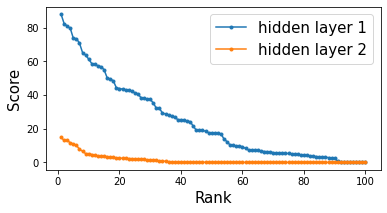

In [10]:
plt.figure(figsize=(6,3))

for i in range(1,3):
    top_k = 784
    linears = mlp.get_linear_layers()
    num_linear = len(linears)
    if i == 0:
        # input layer
        weights = linears[i].linear.weight
        score = torch.sum(torch.abs(weights), dim=0)
        in_fold = linears[0].in_fold
        #print(score.shape)
        score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
    elif i == num_linear:
        # output layer
        weights = linears[i-1].linear.weight
        score = torch.sum(torch.abs(weights), dim=1)
    else:
        weights_in = linears[i-1].linear.weight
        weights_out = linears[i].linear.weight
        score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
    #print(score.shape)
    top_index = torch.flip(torch.argsort(score),[0])[:top_k]
    score = score[top_index]
    
    num = score.shape[0]
    
    plt.plot(np.arange(num)+1, score.detach().cpu().numpy(), marker="o", markersize=3)
    
#plt.xscale('log')

plt.legend(["hidden layer 1", "hidden layer 2"], fontsize=15)
plt.xlabel("Rank", fontsize=15)
plt.ylabel("Score", fontsize=15)

## Visualisation

### Seems like this is only one layer (works)

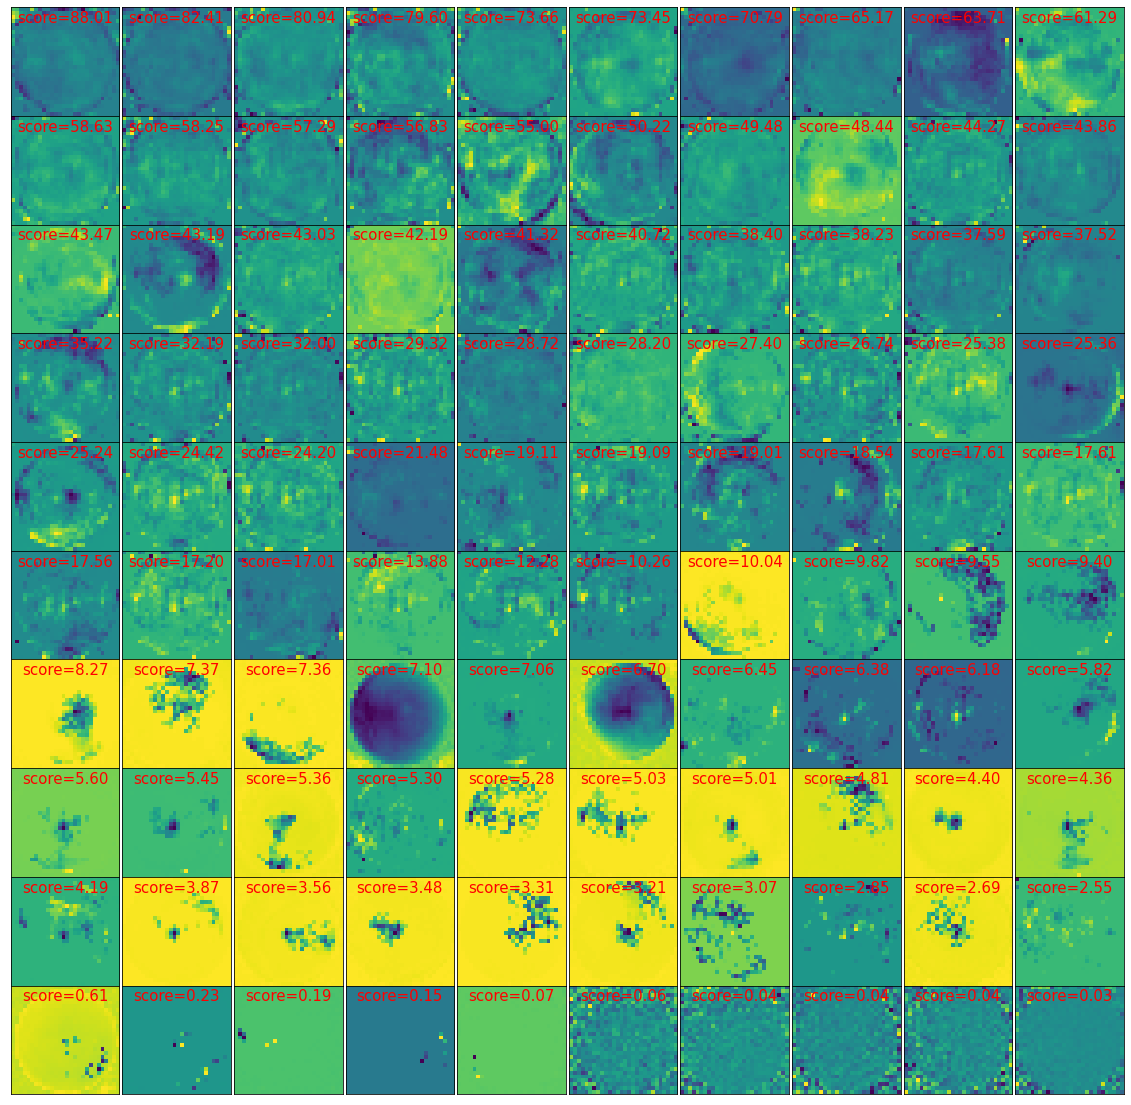

In [11]:
i = 1
top_k = 784
linears = mlp.get_linear_layers()
num_linear = len(linears)
if i == 0:
    # input layer
    weights = linears[i].linear.weight
    score = torch.sum(torch.abs(weights), dim=0)
    in_fold = linears[0].in_fold
    #print(score.shape)
    score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
elif i == num_linear:
    # output layer
    weights = linears[i-1].linear.weight
    score = torch.sum(torch.abs(weights), dim=1)
else:
    weights_in = linears[i-1].linear.weight
    weights_out = linears[i].linear.weight
    score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
#print(score.shape)
top_index = torch.flip(torch.argsort(score),[0])[:top_k]
score = score[top_index]

num = score.shape[0]

features = mlp.linears[0].linear.weight[top_index].reshape(100,28,28).detach().cpu().numpy()

plt.figure(figsize=(20,20))

for i in range(100):
    plt.subplot(10,10,i+1)

    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("score=%.2f"%(score[i]), color="red", fontsize=15,y=0.8)
    
    
plt.subplots_adjust(wspace=0, hspace=0)

if mode == "retinamnist":
    plt.savefig("../results/retina_mnist/final_mnist_retina_features.pdf", bbox_inches="tight")
elif mode == "octmnist":
    plt.savefig("../results/oct_mnist/final_mnist_oct_features.pdf", bbox_inches="tight")





### Seems like these are 3 layers combined (nothing useful)

torch.Size([100, 784])


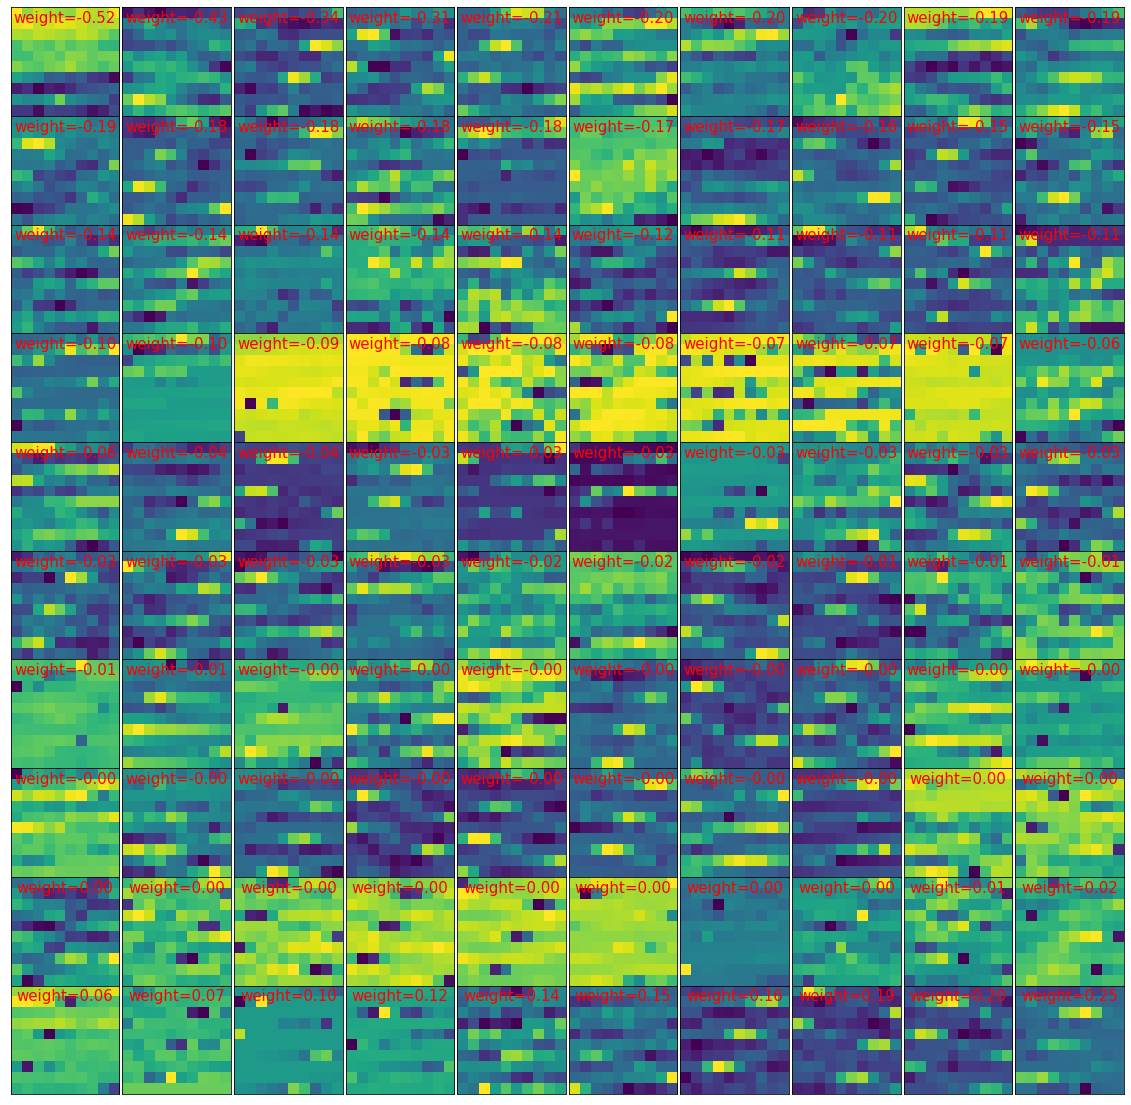

In [88]:


# im_f2 = torch.argsort(mlp.linears[2].linear.weight[4])[-1]
im_f2 = torch.argsort(mlp.linears[2].linear.weight[3])[-1] # [0, n_classes-1]
im_f1 = torch.argsort(mlp.linears[1].linear.weight[im_f2,:])

features = mlp.linears[0].linear.weight[im_f1].reshape(784,10,10).detach().cpu().numpy()

print( mlp.linears[0].linear.weight[im_f1].shape)

plt.figure(figsize=(20,20))
mlp.linears[1].linear.weight[im_f2,:]
for i in range(100):
    plt.subplot(10,10,i+1)

    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("weight=%.2f"%(mlp.linears[1].linear.weight[im_f2,im_f1[i]]), color="red", fontsize=15,y=0.8)
    
    
plt.subplots_adjust(wspace=0, hspace=0)



In [87]:
78400/10/10

784.0

In [ ]:
156800/28/28

In [ ]:
156800/784/200

In [ ]:
40000/200

In [ ]:
np.sqrt(200)

### (nothing useful)

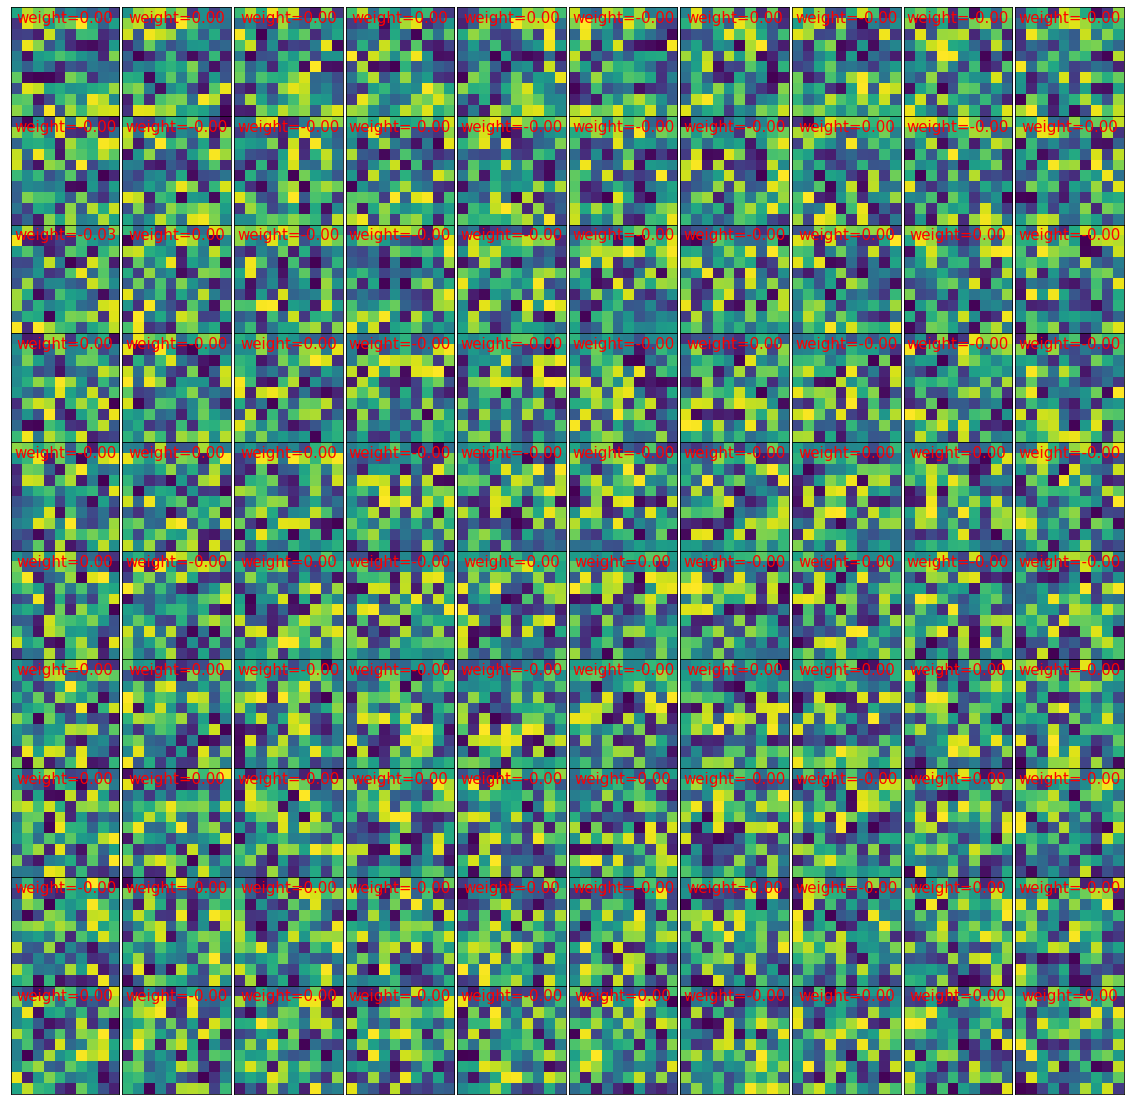

In [89]:


# im_f2 = torch.argsort(mlp.linears[2].linear.weight[4])[-1]
# has a size of 100
im_f2 = torch.argsort(mlp.linears[2].linear.weight[3])[30] # [-1]
features = torch.argsort(mlp.linears[1].linear.weight).reshape(100,10,10).detach().cpu().numpy()



plt.figure(figsize=(20,20))
mlp.linears[1].linear.weight[im_f2,:]
for i in range(100):
    plt.subplot(10,10,i+1)

    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("weight=%.2f"%(mlp.linears[1].linear.weight[im_f2,im_f1[i]]), color="red", fontsize=15,y=0.8)
    
    
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig("../results/retina_mnist/next_layer_mnist_features.pdf", bbox_inches="tight")


In [78]:
234256/10/10

2342.56

In [ ]:
20*20*100

In [ ]:
200*20*10

In [ ]:
40000/28/28

In [ ]:
torch.argsort(mlp.linears[2].linear.weight[0]) # [-1]

In [ ]:
mlp.linears[2].linear.weight[0].shape

In [ ]:
mlp.linears[2].linear.weight.shape

torch.Size([4, 100])

In [ ]:
mlp.linears[1].linear.weight.shape

torch.Size([100, 100])

In [ ]:
mlp.linears[0].linear.weight.shape

In [ ]:
28*28

In [ ]:
import torchsummary

In [ ]:
mlp

In [ ]:
torchsummary.summary(mlp, (1, 28, 28))

In [ ]:
2*1*10*10

In [ ]:
torchsummary.summary(torchvision.models.resnet50().to("cuda"), (3, 128, 128))

In [ ]:
100*28*28

In [ ]:
100*100

In [ ]:
mlp.linears[0].linear

Linear(in_features=784, out_features=100, bias=True)

In [ ]:
import math
math.sqrt(100)

In [ ]:
im_f1

In [ ]:
im_f1.shape

In [ ]:
im_f2

tensor(65, device='cuda:0')

In [ ]:
print(features.shape)

## Rank

FileNotFoundError: [Errno 2] No such file or directory: '../results/mnist/mnist_weights.pdf'

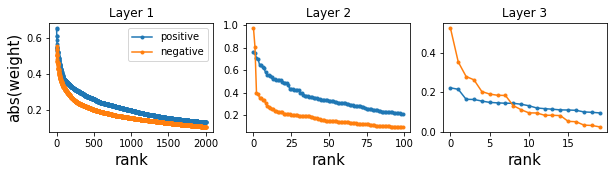

In [90]:
plt.figure(figsize=(10,2))

nums = [2000,100,20]

for i in range(3):

    plt.subplot(1,3,i+1)

    weights = mlp.linears[i].linear.weight.reshape(-1,)
    weights = weights[torch.argsort(weights)]
    plt.plot(-weights[:nums[i]].detach().cpu().numpy(), marker="o", markersize=3)
    plt.plot(weights[-nums[i]:].detach().cpu().numpy()[::-1], marker="o", markersize=3)
    plt.xlabel("rank", fontsize=15)
    if i == 0:
        plt.ylabel("abs(weight)", fontsize=15)
        plt.legend(["positive", "negative"])
    plt.title("Layer {}".format(i+1))
    
    
plt.savefig("../results/mnist/mnist_weights.pdf", bbox_inches="tight")

# BIMT with convolution (this obviously didn't work either)

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
 
    
transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor()
     ])
# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
 
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
 
#batch_size = 32
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
#testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
 
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        #self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(5, 4, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        
        self.conv1x1 = nn.Conv2d(4, 5, kernel_size=(1,1))       
        
        # need global max pooling here??
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        #import torch.nn.functional as F
        #output = F.max_pool2d(input, kernel_size=input.size()[2:])
        
        self.flat = nn.Flatten()
        
 
        #self.fc3 = nn.Linear(8192, 512)
        #self.act3 = nn.ReLU()
        #self.drop3 = nn.Dropout(0.5)
 
        #self.fc4 = nn.Linear(512, 10)
 
    def forward(self, x):
        
        print("shapes")
        print("***************")
        # input 3x32x32, output 32x32x32
        print(x.shape)
        
        x = self.act1(self.conv1(x))
        #x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        print(x.shape)
        
        x = self.pool1(x)
        
        print(x.shape)
        
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        
        print(x.shape)
        
        x = self.pool2(x)
        
        print(x.shape)
        
        x = self.conv1x1(x)
        
        print(x.shape)
        
        # global max pooling
        x = torch.nn.functional.max_pool2d(x, kernel_size=x.size()[2:]).squeeze(-1).squeeze(-1)
        
        print(x.shape)
        
        # x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        #x = self.act3(self.fc3(x))
        #x = self.drop3(x)
        # input 512, output 10
        #x = self.fc4(x)
        return x

model = CIFAR10Model()

model.to("cuda")

"""
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
 
n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))
 
torch.save(model.state_dict(), "cifar10model.pth")
"""

'\nloss_fn = nn.CrossEntropyLoss()\noptimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)\n \nn_epochs = 20\nfor epoch in range(n_epochs):\n    for inputs, labels in trainloader:\n        # forward, backward, and then weight update\n        y_pred = model(inputs)\n        loss = loss_fn(y_pred, labels)\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n \n    acc = 0\n    count = 0\n    for inputs, labels in testloader:\n        y_pred = model(inputs)\n        acc += (torch.argmax(y_pred, 1) == labels).float().sum()\n        count += len(labels)\n    acc /= count\n    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))\n \ntorch.save(model.state_dict(), "cifar10model.pth")\n'

In [14]:
model

CIFAR10Model(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv1x1): Conv2d(4, 5, kernel_size=(1, 1), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [15]:
import torchsummary
torchsummary.summary(model, (1, 100, 100))

shapes
***************
torch.Size([2, 1, 100, 100])
torch.Size([2, 6, 100, 100])
torch.Size([2, 6, 50, 50])
torch.Size([2, 4, 50, 50])
torch.Size([2, 4, 25, 25])
torch.Size([2, 5, 25, 25])
torch.Size([2, 5])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 100, 100]              60
              ReLU-2          [-1, 6, 100, 100]               0
         MaxPool2d-3            [-1, 6, 50, 50]               0
            Conv2d-4            [-1, 4, 50, 50]             220
              ReLU-5            [-1, 4, 50, 50]               0
         MaxPool2d-6            [-1, 4, 25, 25]               0
            Conv2d-7            [-1, 5, 25, 25]              25
           Flatten-8                    [-1, 5]               0
Total params: 305
Trainable params: 305
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04


In [16]:
params = list(model.parameters())
# print(params[0])
for param in params:
    print(param.size())
#print(params[0].size())
#print(params[1].size())

torch.Size([6, 1, 3, 3])
torch.Size([6])
torch.Size([4, 6, 3, 3])
torch.Size([4])
torch.Size([5, 4, 1, 1])
torch.Size([5])


In [158]:
import sys
sys.path.insert(0, "helper")
import torchvision.transforms as transforms

from helper.visualisation.feature_map import *

device="cuda"

# get one example image
ichallenge_data = torchvision.datasets.ImageFolder('examples/example_data/iChallenge')
img, label = ichallenge_data.__getitem__(1)

# tensor preparation
#to_tensor = transforms.ToTensor()
#img = to_tensor(img).to(device)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Resize(350),
    torchvision.transforms.CenterCrop((128,128)),
    torchvision.transforms.ToTensor()
     ])

img = transform(img).to(device)


# layer to focus on
#print("*"*50)
#print("example graph nodes:", get_graph_node_names(model)[0][0:20])
#print("*"*50)
layer = model.conv2 # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv

# run feature map
dd = FeatureMap(model=model, layer=layer, device=device, iterations=None, lr=None)
dd.run(img)
dd.plot()

Layer: Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
shapes
***************
torch.Size([1, 128, 128])
torch.Size([5, 128, 128])
torch.Size([5, 64, 64])
torch.Size([4, 64, 64])
torch.Size([4, 32, 32])
torch.Size([5, 32, 32])
torch.Size([5])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [57]:
350/3

116.66666666666667

In [58]:
2*2*2*2*2*2*2

128

In [160]:
import sys
sys.path.insert(0, "helper")
import torchvision.transforms as transforms

from helper.visualisation.feature_map import *

device="cuda"

# get one example image
ichallenge_data = torchvision.datasets.ImageFolder('examples/example_data/iChallenge')
img, label = ichallenge_data.__getitem__(1)

# tensor preparation
#to_tensor = transforms.ToTensor()
#img = to_tensor(img).to(device)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Resize(350),
    torchvision.transforms.CenterCrop((128,128)),
    torchvision.transforms.ToTensor()
     ])
img = transform(img).to(device)


# layer to focus on
#print("*"*50)
#print("example graph nodes:", get_graph_node_names(model)[0][0:20])
#print("*"*50)
layer = model.conv1x1 # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv

# run feature map
dd = FeatureMap(model=model, layer=layer, device=device, iterations=None, lr=None)
dd.run(img)
dd.plot()

Layer: Conv2d(4, 5, kernel_size=(1, 1), stride=(1, 1))
shapes
***************
torch.Size([1, 128, 128])
torch.Size([5, 128, 128])
torch.Size([5, 64, 64])
torch.Size([4, 64, 64])
torch.Size([4, 32, 32])
torch.Size([5, 32, 32])
torch.Size([5])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [161]:
model

CIFAR10Model(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv1x1): Conv2d(4, 5, kernel_size=(1, 1), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

## visualise channels in filters

torch.Size([4, 5, 3, 3])


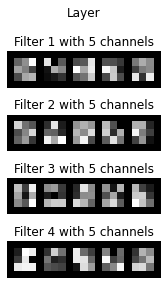

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visChannels(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    
    plt.figure(figsize=(nrow,rows) )
    plt.title(f"Channels with index {ch}")
    plt.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))


def visFilters(tensor, filt=0, allkernels=False, nrow=8, padding=1): 
    f,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(f*c, -1, w, h)
    elif f != 3: tensor = tensor[filt,:,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.title(f"Filter {filt}")
    plt.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))

def visFilters_subplot(subplot, tensor, filt=0, allkernels=False, nrow=8, padding=1): 
    f,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(f*c, -1, w, h)
    elif f != 3: tensor = tensor[filt,:,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    # plt.figure( figsize=(nrow,rows) )
    subplot.set_title(f"Filter {filt+1} with {c} channels")
    subplot.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))
    subplot.axis('off')
    
layer = 1
filter = model.conv2.weight.data.clone()

print(model.conv2.weight.shape)

# need to match the network parameters!!!!
in_channels = 5
out_filters = 4


fig, subplot = plt.subplots(out_filters)
fig.suptitle('Layer')

for filt in range(0, out_filters):
    
    visFilters_subplot(subplot[filt], filter, filt=filt, allkernels=False)

    #plt.axis('off')
    #plt.ioff()
    
plt.tight_layout()
plt.savefig(f"examples/example_results/filter_with_weights.png")
plt.show()
    
if False:    
    for filt in range(0, out_filters):

        visFilters(filter, filt=filt, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.tight_layout()
        #plt.savefig(f"examples/example_results/filter_with_weights.png")
        plt.show()

    for ch in range(0, in_channels):

        visChannels(filter, ch=ch, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()

## understand channel importance

## understand filter importance

# 𝔽𝕦𝕟𝕔𝕥𝕚𝕠𝕟 𝕔𝕒𝕝𝕝𝕤

In [ ]:
configs = Configs()

In [ ]:
if configs.run_decentblocks:
    decentblock_routine(configs)

In [ ]:
if configs.run_decentnet:
    decentnet_routine()

In [ ]:
if configs.run_baseline:
    baseline_routine()

In [ ]:
if configs.run_visualisation:
    visualisation_routine()